<a href="https://colab.research.google.com/github/chuuuuu/machine_learning_2021/blob/main/homework/hw05/hw05_bt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !ps
# !kill 50

# **Homework 5 - Sequence-to-sequence**
this is part of the homework. in this section, we'll build a back-translation model to generate synthetic dataset from monolingual dataset.


# Sequence-to-Sequence Introduction
- Typical sequence-to-sequence (seq2seq) models are encoder-decoder models, which usually consists of two parts, the encoder and decoder, respectively. These two parts can be implemented with recurrent neural network (RNN) or transformer, primarily to deal with input/output sequences of dynamic length.
- **Encoder** encodes a sequence of inputs, such as text, video or audio, into a single vector, which can be viewed as the abstractive representation of the inputs, containing information of the whole sequence.
- **Decoder** decodes the vector output of encoder one step at a time, until the final output sequence is complete. Every decoding step is affected by previous step(s). Generally, one would add "< BOS >" at the begining of the sequence to indicate start of decoding, and "< EOS >" at the end to indicate end of decoding.

![seq2seq](https://i.imgur.com/0zeDyuI.png)

# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Download and import required packages

In [3]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

Requirement already up-to-date: jupyter in /usr/local/lib/python3.7/dist-packages (1.0.0)
Requirement already up-to-date: ipywidgets in /usr/local/lib/python3.7/dist-packages (7.6.3)
fatal: destination path 'fairseq' already exists and is not an empty directory.
HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for fairseq: filename=fairseq-1.0.0a0+9a1c497-cp37-cp37m-linux_x86_64.whl size=2851257 sha256=479fa48d5b70ec6cce12fe0743ab81b7d9c58def600b001b7dae12a2ea988eba
  Stored in directory: /tmp/pip-ephem-wheel-cache-ljp4h_sq/wheels/94/b2/67/6399f5bcb823dc3a8b1e84965aaae15af9ed863fee98a59129
Successfully built fairseq
  Found existing installation: fairseq 1.0.0a0+9a1c497
    Uninstalling fairseq-1.0.0a0+9a1c497:
      Successfully uninstalled fairseq-1.0.0a0+9a1c497


In [4]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Configuration for Experiments
```
workspace
+-- data
|   +-- raw
|   |   |   (get from dataset)
|   |   +-- ted2020
|   |   |   +-- train_dev.raw.{lang}
|   |   |   +-- test.raw.{lang}
|   |   |   |   
|   |   |   |   (after clean corpus)
|   |   |   +-- train_dev.raw.clean.{lang}
|   |   |   +-- test.raw.clean.{lang}
|   |   |   |   
|   |   |   |   (split train_dev)
|   |   |   +-- train.clean.{lang}
|   |   |   +-- dev.clean.{lang}
|   |   |   |   
|   |   |   |   (after subword unit)
|   |   |   +-- train.{lang}
|   |   |   +-- dev.{lang}
|   |   |   +-- test.{lang}
|   |   |   
|   |   |   (get from dataset)
|   |   +-- mono
|   |   |   +-- mono.raw.{lang}
|   |   |   |   
|   |   |   |   (after clean corpus)
|   |   |   +-- mono.raw.clean.{lang}
|   |   |   |   
|   |   |   |   (after subword unit)
|   |   |   +-- mono.{lang}
|   |   |
|   |   |   (get from predict mono)
|   |   +-- synthetic
|   |       +-- mono.raw.{lang}
|   |       |   
|   |       |   (after clean corpus)
|   |       +-- mono.raw.clean.{lang}
|   |       |   
|   |       |   (after subword unit)
|   |       +-- mono.{lang}
|   |
|   +-- bin
|       |   (get from binarize ted2020)
|       +-- ted2020
|       |   +-- ...
|       |
|       |   (get from binarize mono)
|       +-- mono
|       |   +-- ...
|       |
|       |   (get from binarize synthetic)
|       +-- synthetic
|       |   +-- ...
|       |
|       |   (get from bin/ted2002 and bin/synthetic)
|       +-- ted2020_with_synthetic (goal)
|           +-- ...
|    
|
+-- checkpoints
    +-- ft
    |   +--sample
    |   +--best_checkpoint
    |   +--last_checkpoint
    |   +--...
    |
    +-- bt
        +--sample
        +--best_checkpoint
        +--last_checkpoint
        +--...

```

In [5]:
WORKSPACE = './gdrive/MyDrive/ColabNotebooks/HW5'

# https://fairseq.readthedocs.io/en/latest/_modules/fairseq/tasks/fairseq_task.html#FairseqTask.build_generator
config = Namespace(
    # dir structure
    save_dir = f'{WORKSPACE}/checkpoints/bt',
    data_dir = f'{WORKSPACE}/data',
    raw_dir = f'{WORKSPACE}/data/raw',
    bin_dir = f'{WORKSPACE}/data/bin',

    # ted2020
    ted_name = 'ted2020',
    src_lang = 'zh',
    tgt_lang = 'en',

    # mono
    mono_name = 'mono',
    mono_src_lang = 'zh',
    mono_tgt_lang = 'en',

    # synthetic
    syn_name = 'synthetic',

    # ted2020 and synthetic
    tns_name = 'ted2020_with_synthetic',

    # cpu threads when fetching & processing data.
    num_workers = 2,

    max_tokens = 8192,

    accum_steps = 2,

    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor = 2,
    lr_warmup = 4000,

    # clipping gradient norm helps alleviate gradient exploding
    clip_norm = 1.0,

    # maximum epochs for training
    max_epoch = 60,
    start_epoch = 1,

    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",

    # checkpoints
    keep_last_epochs = 5,

    # if resume from checkpoint name (under savedir)
    resume = None,

    # logging
    use_wandb = False,

    # beam size for beam search, not uesd?
    beam=5,

    # generate sequences of maximum length ax + b, where x is the source length, not used?
    max_len_a=1.2,
    max_len_b=10, 
)

raw_ted_dir = Path(config.raw_dir).absolute() / config.ted_name
raw_ted_dir.mkdir(parents=True, exist_ok=True)

raw_mono_dir = Path(config.raw_dir).absolute() / config.mono_name
raw_mono_dir.mkdir(parents=True, exist_ok=True)

raw_syn_dir = Path(config.raw_dir).absolute() / config.syn_name
raw_syn_dir.mkdir(parents=True, exist_ok=True)

# Fix random seed

In [6]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset Information

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

# Dataset Download

## Download and extract
get
- train_dev.raw.en
- train_dev.raw.zh
- test.raw.en
- test.raw.zh


In [7]:
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)

for u, f in zip(urls, file_names):
    path = raw_ted_dir/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {raw_ted_dir}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {raw_ted_dir}
!mv {raw_ted_dir/'raw.en'} {raw_ted_dir/'train_dev.raw.en'}
!mv {raw_ted_dir/'raw.zh'} {raw_ted_dir/'train_dev.raw.zh'}
!mv {raw_ted_dir/'test.en'} {raw_ted_dir/'test.raw.en'}
!mv {raw_ted_dir/'test.zh'} {raw_ted_dir/'test.raw.zh'}

raw.en
raw.zh
test.en
test.zh


## Language

In [8]:
!head '{raw_ted_dir}/train_dev.raw.{config.src_lang}' -n 5
!head '{raw_ted_dir}/train_dev.raw.{config.tgt_lang}' -n 5

非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！
Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.


## Preprocess files

In [9]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    
    # en
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=4, max_len=250, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len >= ratio or s2_len/s1_len >= ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [10]:
clean_corpus(raw_ted_dir/'train_dev.raw', config.src_lang, config.tgt_lang)
clean_corpus(raw_ted_dir/'test.raw', config.src_lang, config.tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/content/gdrive/MyDrive/ColabNotebooks/HW5/data/raw/ted2020/train_dev.raw.clean.zh & en exists. skipping clean.
/content/gdrive/MyDrive/ColabNotebooks/HW5/data/raw/ted2020/test.raw.clean.zh & en exists. skipping clean.


In [11]:
!head '{raw_ted_dir}/train_dev.raw.clean.{config.src_lang}' -n 5
!head '{raw_ted_dir}/train_dev.raw.clean.{config.tgt_lang}' -n 5

真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !
我曾搭乘副總統專機八年 。
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
I flew on Air Force Two for eight years .


## Split into train/valid

In [12]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [13]:
if (raw_ted_dir/f'train.clean.{config.src_lang}').exists() \
and (raw_ted_dir/f'train.clean.{config.tgt_lang}').exists() \
and (raw_ted_dir/f'valid.clean.{config.src_lang}').exists() \
and (raw_ted_dir/f'valid.clean.{config.tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    # get shuffled labels (used to decide wheather the data is train_data or valid_data )
    line_num = sum(1 for line in open(f'{raw_ted_dir}/train_dev.raw.clean.{config.src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)

    # write into train/valid
    for lang in [config.src_lang, config.tgt_lang]:
        train_f = open(f'{raw_ted_dir}/train.clean.{lang}', 'w')
        valid_f = open(f'{raw_ted_dir}/valid.clean.{lang}', 'w')
        count = 0
        for line in open(f'{raw_ted_dir}/train_dev.raw.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [14]:
import sentencepiece as spm
vocab_size = 16000
if (raw_ted_dir/f'spm{vocab_size}.model').exists():
    print(f'{raw_ted_dir}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{raw_ted_dir}/train.clean.{config.src_lang}',
                        f'{raw_ted_dir}/valid.clean.{config.src_lang}',
                        f'{raw_ted_dir}/train.clean.{config.tgt_lang}',
                        f'{raw_ted_dir}/valid.clean.{config.tgt_lang}']),
        model_prefix=f'{raw_ted_dir}/spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/content/gdrive/MyDrive/ColabNotebooks/HW5/data/raw/ted2020/spm16000.model exists. skipping spm_train.


In [15]:
spm_model = spm.SentencePieceProcessor(model_file=f'{raw_ted_dir}/spm{vocab_size}.model')
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [config.src_lang, config.tgt_lang]:
        out_path = raw_ted_dir/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(raw_ted_dir/f'{split}.{lang}', 'w') as out_f:
                with open(raw_ted_dir/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/content/gdrive/MyDrive/ColabNotebooks/HW5/data/raw/ted2020/train.zh exists. skipping spm_encode.
/content/gdrive/MyDrive/ColabNotebooks/HW5/data/raw/ted2020/train.en exists. skipping spm_encode.
/content/gdrive/MyDrive/ColabNotebooks/HW5/data/raw/ted2020/valid.zh exists. skipping spm_encode.
/content/gdrive/MyDrive/ColabNotebooks/HW5/data/raw/ted2020/valid.en exists. skipping spm_encode.


In [16]:
!head '{raw_ted_dir}/train.{config.src_lang}' -n 5
!head '{raw_ted_dir}/train.{config.tgt_lang}' -n 5

▁ 真是 一大 榮幸 ▁。 ▁我 非常 感激 ▁。
▁這個 研 討 會 給我 留下 了 極為 深刻 的 印象 ▁, ▁我想 感謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼說 ▁, ▁有 部份 原因 是因為我 真的 有 需要 ▁!
▁請 你們 設 身處 地 為我 想一想 ▁!
▁我曾 搭 乘 副 總統 專 機 八 年 ▁。
▁and ▁it ' s ▁truly ▁a ▁great ▁honor ▁to ▁have ▁the ▁opportunity ▁to ▁come ▁to ▁this ▁stage ▁twice ▁; ▁i ' m ▁extreme ly ▁grateful ▁.
▁i ▁have ▁been ▁blow n ▁away ▁by ▁this ▁conference ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁nice ▁comment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁position ▁.
▁i ▁fle w ▁on ▁air ▁force ▁two ▁for ▁eight ▁years ▁.


## Binarize the data with fairseq

In [17]:
bin_ted_dir = Path(config.bin_dir).absolute() / config.ted_name

if bin_ted_dir.exists():
    print(bin_ted_dir, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {config.src_lang} \
        --target-lang {config.tgt_lang} \
        --trainpref {raw_ted_dir/'train'} \
        --validpref {raw_ted_dir/'valid'} \
        --testpref {raw_ted_dir/'test'} \
        --destdir {bin_ted_dir} \
        --joined-dictionary \
        --workers 2

!ls {bin_ted_dir}

/content/gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020 exists, will not overwrite!
dict.en.txt	   mono.zh-en.zh.idx  test.zh-en.zh.idx   valid.zh-en.en.bin
dict.zh.txt	   preprocess.log     train.zh-en.en.bin  valid.zh-en.en.idx
mono.zh-en.en.bin  test.zh-en.en.bin  train.zh-en.en.idx  valid.zh-en.zh.bin
mono.zh-en.en.idx  test.zh-en.en.idx  train.zh-en.zh.bin  valid.zh-en.zh.idx
mono.zh-en.zh.bin  test.zh-en.zh.bin  train.zh-en.zh.idx


# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [18]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.save_dir).stem, config=config)

# CUDA Environment

In [19]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2021-07-02 20:27:34 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-07-02 20:27:34 | INFO | fairseq.utils | rank   0: capabilities =  7.0  ; total memory = 15.782 GB ; name = Tesla V100-SXM2-16GB                    
2021-07-02 20:27:34 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [20]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=str(bin_ted_dir),
    source_lang=config.src_lang,
    target_lang=config.tgt_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-07-02 20:27:34 | INFO | fairseq.tasks.translation | [zh] dictionary: 15992 types
2021-07-02 20:27:34 | INFO | fairseq.tasks.translation | [en] dictionary: 15992 types


In [21]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-07-02 20:27:34 | INFO | hw5.seq2seq | loading data for epoch 1
2021-07-02 20:27:34 | INFO | fairseq.data.data_utils | loaded 388,365 examples from: /content/gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020/train.zh-en.zh
2021-07-02 20:27:34 | INFO | fairseq.data.data_utils | loaded 388,365 examples from: /content/gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020/train.zh-en.en
2021-07-02 20:27:34 | INFO | fairseq.tasks.translation | /content/gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020 train zh-en 388365 examples
2021-07-02 20:27:34 | INFO | fairseq.data.data_utils | loaded 3,922 examples from: /content/gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020/valid.zh-en.zh
2021-07-02 20:27:34 | INFO | fairseq.data.data_utils | loaded 3,922 examples from: /content/gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020/valid.zh-en.en
2021-07-02 20:27:34 | INFO | fairseq.tasks.translation | /content/gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020 valid zh-en 3922 examples


In [22]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([ 5846, 12913,   927,  6021,   308,    32,   120,  2002,   191,   756,
          200,     2]),
 'target': tensor([ 3523, 10027,    32,    19,    13,     8,    15,  2009,   200,     2])}
'Source: 克里斯・安徒生:一言為定 !'
"Target: chris anderson: it's a deal !"


## Dataset Iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [23]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-07-02 20:27:34 | WARNING | fairseq.tasks.fairseq_task | 2,049 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[738, 349, 3165, 51, 1359, 1003, 830, 3181, 1706, 3834]


{'id': tensor([428]),
 'net_input': {'prev_output_tokens': tensor([[   2,   19,   13,    8,   17, 1211,    5,   19,   13,    8,   17,  561,
            180,   83,    5,    1]]),
  'src_lengths': tensor([11]),
  'src_tokens': tensor([[   1,    1,    1,    1,    1,  207,   34,  999,    9,  207,  339,   34,
            999, 2781,    9,    2]])},
 'nsentences': 1,
 'ntokens': 15,
 'target': tensor([[  19,   13,    8,   17, 1211,    5,   19,   13,    8,   17,  561,  180,
            83,    5,    2,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [24]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [25]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [26]:
# HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration
reference implementation

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [27]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=6,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# # HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [28]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [29]:
model = build_model(arch_args, task)
logger.info(model)

2021-07-02 20:27:36 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(15992, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bi

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [30]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [31]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## Scheduling Visualized

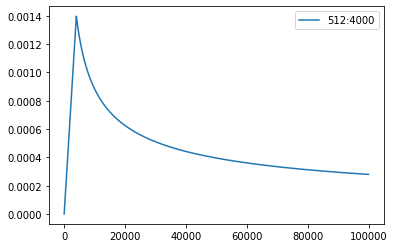

In [32]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [33]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [34]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [35]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights

In [36]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.save_dir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.src_lang}-{config.tgt_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.save_dir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [37]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [38]:
!nvidia-smi

Fri Jul  2 20:27:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    37W / 300W |   1579MiB / 16160MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [39]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-07-02 20:27:40 | INFO | hw5.seq2seq | task: TranslationTask
2021-07-02 20:27:40 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-07-02 20:27:40 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-07-02 20:27:40 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-07-02 20:27:40 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-07-02 20:27:40 | INFO | hw5.seq2seq | num. model params: 60,516,352 (num. trained: 60,516,352)
2021-07-02 20:27:40 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [40]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-07-02 20:27:43 | INFO | hw5.seq2seq | loaded checkpoint gdrive/MyDrive/ColabNotebooks/HW5/checkpoints/bt/checkpoint_last.pt: step=1256 loss=4.4145307540893555 bleu=6.0724107106310345


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


KeyboardInterrupt: ignored

## Confirm model weights used to generate submission

In [41]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="checkpoint_best.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-07-02 20:28:14 | INFO | hw5.seq2seq | loaded checkpoint gdrive/MyDrive/ColabNotebooks/HW5/checkpoints/bt/checkpoint_best.pt: step=unknown loss=4.4145307540893555 bleu=6.0724107106310345
2021-07-02 20:28:14 | INFO | hw5.seq2seq | begin validation


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


2021-07-02 20:28:37 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-07-02 20:28:37 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-07-02 20:28:37 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-07-02 20:28:39 | INFO | hw5.seq2seq | example source: 第二:我建議增加學校的人數
2021-07-02 20:28:39 | INFO | hw5.seq2seq | example hypothesis: second: i'm going to give you a lot of people in school .
2021-07-02 20:28:39 | INFO | hw5.seq2seq | example reference: second , i propose increasing the overall population of the school .
2021-07-02 20:28:39 | INFO | hw5.seq2seq | validation loss:	4.4145
2021-07-02 20:28:39 | INFO | hw5.seq2seq | BLEU = 6.07 36.3/10.5/3.8/1.4 (BP = 0.899 ratio = 0.904 hyp_len = 68719 ref_len = 76024)


## Generate Prediction

In [42]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

# Generate synthetic data with backward model 

### Download monolingual data

In [46]:
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = raw_mono_dir/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {raw_mono_dir}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {raw_mono_dir}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

!mv {raw_mono_dir/'ted_zh_corpus.deduped'} {raw_mono_dir/'mono.raw.zh'}
!cp {raw_mono_dir/'mono.raw.zh'} {raw_mono_dir/'mono.raw.en'}

ted_zh_corpus.deduped.gz is exist, skip downloading


In [47]:
!head "{raw_mono_dir}/mono.raw.{config.mono_src_lang}" -n 5

在 16 世紀中葉 意大利人被一種男歌手迷住了 那種男歌手的音域廣闊，包含的音高 先前是一般成年男性不可能達到的
但是，這天賦有一個很高的代價
要防止他們變聲 這些歌手在青春期前被閹割 來停止荷爾蒙的變化， 以免他們的聲線變低沉
被稱為「閹伶」，他們輕輕的、 天使般的聲音在整個歐洲很有名 直到這個殘酷的程序， 在 19 世紀被禁止
雖然阻止聲帶的成長， 可以產生一個非凡廣闊的音域 但自然發展的聲音， 已經具有極多的可能性


### clean

In [48]:
clean_corpus(f'{raw_mono_dir}/mono.raw', config.mono_src_lang, config.mono_tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/content/gdrive/MyDrive/ColabNotebooks/HW5/data/raw/mono/mono.raw.clean.zh & en exists. skipping clean.


In [49]:
!head "{raw_mono_dir}/mono.raw.clean.{config.mono_src_lang}" -n 5

在16世紀中葉意大利人被一種男歌手迷住了那種男歌手的音域廣闊 , 包含的音高先前是一般成年男性不可能達到的
但是 , 這天賦有一個很高的代價
要防止他們變聲這些歌手在青春期前被閹割來停止荷爾蒙的變化 , 以免他們的聲線變低沉
被稱為 「 閹伶 」 , 他們輕輕的、天使般的聲音在整個歐洲很有名直到這個殘酷的程序 , 在19世紀被禁止
雖然阻止聲帶的成長 , 可以產生一個非凡廣闊的音域但自然發展的聲音 , 已經具有極多的可能性


### subword units

In [50]:
in_tag = {
    'mono': 'mono.raw.clean',
}
for split in ['mono']:
    for lang in [config.mono_src_lang, config.mono_tgt_lang]:
        out_path = raw_mono_dir/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(raw_mono_dir/f'{split}.{lang}', 'w') as out_f:
                with open(raw_mono_dir/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/content/gdrive/MyDrive/ColabNotebooks/HW5/data/raw/mono/mono.zh exists. skipping spm_encode.
/content/gdrive/MyDrive/ColabNotebooks/HW5/data/raw/mono/mono.en exists. skipping spm_encode.


In [51]:
 !head "{raw_mono_dir}/mono.{config.mono_src_lang}" -n 5

▁在 16 世紀 中 葉 意 大 利 人 被 一種 男 歌 手 迷 住了 那種 男 歌 手 的 音 域 廣 闊 ▁, ▁ 包含 的 音 高 先前 是 一般 成 年 男性 不可能 達到 的
▁但是 ▁, ▁這 天 賦 有一個 很高 的 代價
▁要 防止 他們 變 聲 這些 歌 手 在 青 春 期 前 被 閹 割 來 停止 荷爾蒙 的變化 ▁, ▁以 免 他們的 聲 線 變 低 沉
▁ 被稱為 ▁「 ▁ 閹 伶 ▁」 ▁, ▁他們 輕 輕 的 、 天 使 般 的聲音 在 整個 歐洲 很有 名 直到 這個 殘酷 的 程序 ▁, ▁在 19 世紀 被 禁止
▁雖然 阻止 聲 帶 的 成長 ▁, ▁可以 產生 一個 非凡 廣 闊 的 音 域 但 自然 發展 的聲音 ▁, ▁ 已經 具有 極 多 的可能性


### Binarize

use fairseq to binarize data

In [52]:
bin_mono_dir = Path(config.bin_dir).absolute() / config.mono_name
src_dict_file = bin_ted_dir/'dict.zh.txt'
tgt_dict_file = src_dict_file

if bin_mono_dir.exists():
    print(bin_mono_dir, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang 'zh' \
        --target-lang 'en' \
        --trainpref {raw_mono_dir/'mono'} \
        --destdir {bin_mono_dir} \
        --srcdict {src_dict_file} \
        --tgtdict {tgt_dict_file} \
        --workers 2

!ls {bin_mono_dir}

/content/gdrive/MyDrive/ColabNotebooks/HW5/data/bin/mono exists, will not overwrite!
dict.en.txt  preprocess.log	 train.zh-en.en.idx  train.zh-en.zh.idx
dict.zh.txt  train.zh-en.en.bin  train.zh-en.zh.bin


### Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/bindata/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [54]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/bindata/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp "{bin_mono_dir}/train.zh-en.zh.bin" "{bin_ted_dir}/mono.zh-en.zh.bin"
!cp "{bin_mono_dir}/train.zh-en.zh.idx" "{bin_ted_dir}/mono.zh-en.zh.idx"
!cp "{bin_mono_dir}/train.zh-en.en.bin" "{bin_ted_dir}/mono.zh-en.en.bin"
!cp "{bin_mono_dir}/train.zh-en.en.idx" "{bin_ted_dir}/mono.zh-en.en.idx"

In [55]:
# hint: do prediction on split='mono' to create prediction_file
out_path = raw_syn_dir/f'mono.raw.{config.mono_tgt_lang}'
if out_path.exists():
    print(f"{out_path} exists. skipping prediction.")
else:
    generate_prediction(model, task, split="mono", outfile=f'{raw_syn_dir}/mono.raw.{config.mono_tgt_lang}')
    !cp "{raw_mono_dir}/mono.raw.clean.{config.mono_src_lang}" "{raw_syn_dir}/mono.raw.{config.mono_src_lang}"

/content/gdrive/MyDrive/ColabNotebooks/HW5/data/raw/synthetic/mono.raw.en exists. skipping prediction.


In [56]:
!head "{raw_syn_dir}/mono.raw.{config.mono_src_lang}" -n 5
!head "{raw_syn_dir}/mono.raw.{config.mono_tgt_lang}" -n 5

在16世紀中葉意大利人被一種男歌手迷住了那種男歌手的音域廣闊 , 包含的音高先前是一般成年男性不可能達到的
但是 , 這天賦有一個很高的代價
要防止他們變聲這些歌手在青春期前被閹割來停止荷爾蒙的變化 , 以免他們的聲線變低沉
被稱為 「 閹伶 」 , 他們輕輕的、天使般的聲音在整個歐洲很有名直到這個殘酷的程序 , 在19世紀被禁止
雖然阻止聲帶的成長 , 可以產生一個非凡廣闊的音域但自然發展的聲音 , 已經具有極多的可能性
in the 20th century , there was a young guy in the 19th century .
but there's a lot of money .
to protect them that they're going to be able to get their hands in the middle of the surresions , and they're very low .
it's called " surresion , " they're going to be very good at the 19th century in 19th century , but in 19th century , in 19th century .
although they're going to be able to make a huge amount of sound , but it's very important , it's very important , it's very important .


### clean synthetic

In [ ]:
# clean corpus
clean_corpus(f'{raw_syn_dir}/mono.raw', config.mono_src_lang, config.mono_tgt_lang, ratio=-1, min_len=-1, max_len=-1)

### subword units

In [ ]:
# subword units
in_tag = {
    'mono': 'mono.raw.clean',
}
for split in ['mono']:
    for lang in [config.mono_src_lang, config.mono_tgt_lang]:
        out_path = raw_syn_dir/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(raw_syn_dir/f'{split}.{lang}', 'w') as out_f:
                with open(raw_syn_dir/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

In [ ]:
!head "{raw_syn_dir}/mono.{config.mono_src_lang}" -n 5
!head "{raw_syn_dir}/mono.{config.mono_tgt_lang}" -n 5

### Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [ ]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: use fairseq to binarize these two files again
bin_syn_dir = Path(config.bin_dir).absolute() / config.syn_name
src_dict_file = bin_ted_dir/'dict.en.txt'
tgt_dict_file = bin_ted_dir/'dict.zh.txt'

if bin_syn_dir.exists():
    print(bin_syn_dir, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'en'\
        --target-lang 'zh'\
        --trainpref {raw_syn_dir/'mono'} \
        --destdir {bin_syn_dir}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

!ls {bin_syn_dir}

In [ ]:
# create a new dataset from all the files prepared above
bin_tns_dir = Path(config.bin_dir).absolute() / config.tns_name

!cp -r {bin_ted_dir} {bin_tns_dir}

!cp "{bin_syn_dir}/train.en-zh.zh.bin" "{bin_tns_dir}/train1.en-zh.zh.bin"
!cp "{bin_syn_dir}/train.en-zh.zh.idx" "{bin_tns_dir}/train1.en-zh.zh.idx"
!cp "{bin_syn_dir}/train.en-zh.en.bin" "{bin_tns_dir}/train1.en-zh.en.bin"
!cp "{bin_syn_dir}/train.en-zh.en.idx" "{bin_tns_dir}/train1.en-zh.en.idx"

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/bindata/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html